# PyCall Lecture

2017-09-20 RubyData Workshop in RubyKaigi 2017


# Today's Contents

## Outline

1. Preparation
   1. How to install pycall and related libraries
   2. How to install Python for pycall
2. Gettings started to pycall
   1. What is pycall
   2. What can we do by pycall
   3. Mechanisms of pycall
3. Demonstrations

## Goal

- Understanding what is and what can we do pycall
- Understanding how to reproduce the demonstrations
- Joining to Ruby's data science ecosystems

# Preparation

## How to install pycall and related libraries

You can simplly install pycall and related libraries by `gem install` command like below.

```console
$ gem install pycall
$ gem install numpy
$ gem install matplotlib
$ gem install pandas
```

## How to install Python for pycall

Pycall loads the shared library of Python dynamically by using fiddle.
So you must install Python's shared library.

If you use UNIX-like operating system, there are three ways to install Python with its shared library.

1. Using pyenv
2. Using Anaconda
3. Build from source

If you use Windows, the former two ways in this list are available.

### Using pyenv

Pyenv is Python's version manager.  This was made based on rbenv; the similarity of their names isn't just contingency.

You can install pyenv by following [this instruction](https://github.com/pyenv/pyenv#installation).

In this case, you should use `pip` for installing Python libraries, such as numpy and pandas, which you want to use from Ruby.


### Using Anaconda

You can install Python by using Anaconda or Miniconda, too.  The instruction is available here: https://docs.continuum.io/anaconda/install/

Unfortunately, pycall couldn't use with Anaconda or Miniconda due to the issue [#36](https://github.com/mrkn/pycall.rb/issues/36).
It has already been fixed in [#37](https://github.com/mrkn/pycall.rb/pull/37), so you will be able to use pycall with Anaconda or Miniconda, soon.

### Build from source

- https://docs.python.org/3/using/unix.html
- https://docs.python.org/2/using/unix.html

You have to specify `--enable-shared` for the configure script.
You can use `--enable-framework` instead of `--enable-shared` if you use macOS.

In this case, you should use `pip` like the case of pyenv, so you need to install `pip` by using `get-pip.py`.  See the above section for the instruction to install `pip`.

# Getting started to pycall

## What is pycall

Pycall consists of two parts.

1. Ruby binding of Python's shared library, that is `libpython.so`
2. Porotocl translater of object systems between Ruby and Python

CPython provides C APIs that you can use to embed Python interpreter into your application.
The first part is Ruby binding of that APIs.  In this Python C APIs, objects in Python are represented as pointers.
To handle these pointers from Ruby, pycall's fundation is written as a C extension library.

There are differences of object systems between Ruby and Python.  The second part is the protocol translator that absorbs this differences.  For example, we can call objects themselves with attaching `(args...)` like `obj(args...)`.  This synatx is interpreted as `obj.__call__(args...)` internally in Python.  In contrast, Ruby's correspondence is `.(args...)` syntax-sugar, so we should write it as `obj.(args...)` instead of `obj(args...)` in Ruby.  It means, without the protocol translation part, we need to write `obj.method.(args...)` instead of `obj.method(args...)` for Python objects in Ruby.  Pycall's protocol translation enable us to write as natual as possible in Ruby.

## What we can do with pycall

### Importing Python module

We can take Python modules in Ruby by using `PyCall.import_module`.  Let's try it.

In [1]:
require 'pycall'

pymath = PyCall.import_module('math')

<module 'math' from '/usr/local/lib/python3.6/lib-dynload/math.cpython-36m-x86_64-linux-gnu.so'>

The variable `pymath` holds Python math module.  This math module is enclosed by a Ruby object.  A Ruby object that encloses a Python object like this is called *a wrapper object*.

PyCall defines methods in wrapper objects, that is used for accessing objects' attributes.
So we can access Python's `math.pi` by calling `pi` method of the wrapper object in the variable `pymath`.

In [2]:
pymath.pi

3.141592653589793

This value is Ruby's Float object that is automatically converted from Python's float object.

In [3]:
pymath.pi.class

Float

Pycall maps Python object's instance methods to wrapper object's instance methods.
So we can call Python's `math.sin` through `pymath.sin` here.

In [4]:
pymath.sin(pymath.pi)

1.2246467991473532e-16

Python's `math.pi` is the same value of Ruby's `Math::PI`.

In [5]:
pymath.pi == Math::PI

true

And, the result of Python's `sin` function is equal to the result of Ruby's `sin` function.

In [6]:
pymath.sin(pymath.pi) == Math.sin(Math::PI)

true

We can pass Ruby's Float objects to Python's `sin` function because Pycall automatically convert to Ruby's Float value to Python's float value.

In [7]:
pymath.sin(Math::PI)

1.2246467991473532e-16

As we have seen so far, PyCall has the mechanism to handle Python objects from Ruby, so we can use Python objects very naturally in Ruby.

You can import your own Python code as modules by using `PyCall.import_module`.  As PyCall maps Python's `sys.path` to `PyCall.sys.path`, you can register the path of your Python code to `sys.path` by `PyCall.sys.path.append(...)`, and then you can import your own Python code.

For example, the following Ruby script imports `foo.py` in the same directory.

```ruby
require 'pycall'
PyCall.sys.path.append(__dir__)  # Append the same directory of the script
foo = PyCall.import_module('foo')
```

### Executing Python code

Python で記述したい処理があるが、独立したファイルに置くには小さいと感じる場合、`PyCall.exec` と `PyCall.eval` を使うと Ruby スクリプト中に Python コードを埋め込めます。
`PyCall.exec` は、クラス定義などのステートメントを実行するために使います。対して `PyCall.eval` は、式を評価するために用います。

You can embed Python code in you Ruby code by using `PyCall.exec` or `PyCall.eval`.
They are useful your python code is too small to separate.
`PyCall.exec` is used for evaluating statements like class definitions.
In contrast, `PyCall.eval` is used for an expression.

In [8]:
PyCall.exec(<<PYTHON)
class Foo(object):
    def __init__(self, x):
        self.x = x

    def double(self):
        return self.x * self.x
PYTHON

The above code defines `Foo` class in Python's `__main__` module.
You can take this class by using `PyCall.eval`:

In [9]:
PyCall.eval('Foo')

<class '__main__.Foo'>

In [10]:
foo = PyCall.eval('Foo').new(42)

In [11]:
foo.x

42

In [12]:
foo.double

1764

## Mechanisms of pycall

In this section, we describes the mechanisms how pycall bridges between Ruby and Python.

The contents in this section is:

- The object system of pycall
- The type conversion system of pycall
- The amount of the overhead of pycall

---

- Python の type 型のオブジェクトは他の型のオブジェクトと区別しておきたいので、そのポインタを `PyTypePtr` オブジェクトとして boxing する。
- Ruby オブジェクトを Python 側に持って行く際に Python 側に作るオブジェクトも他と区別しておきたいので、そのポインタを `PyRubyPtr` オブジェクトとして boxing する。


### Pycall's object system

In C language layer, a Python object is represented as a pointer that indicates the address of a `PyObject` structure.
Pycall handles such pointers by putting into a `PyCall::PyPtr` object.

![](pyptr.png)

For example, the following Ruby code,

```ruby
pymath = PyCall.import_module("math")
```

that imports Python's math module, acts like the following diagram.

![](pymath.png)

`PyCall.wrap_ruby_object` method generates a Python object that wraps the Ruby object given as an argument.  Such Python object is an instance of `PyCall.ruby_object` type in Python, and its entity is `PyRubyObject` structure in C layer.  A wrapped Ruby object is kept in `ruby_object` field of this structure.  The folloing diagram illustrates this relationship.

![](pyrubyptr.png)

Wrapped Ruby objects are put into a hash table, called GC guard table, managed in PyCall internally so that GC doesn't sweep the wrapped Ruby objects.  Of course, the wrapped Ruby objects are deleted from the GC guard table when the wrapper Python object is destroyed.

### Pycall's type system

Pycall automatically converts the following primitive types between Ruby and Python.

| Ruby | Python |
| --- | --- |
| Integer | int, long |
| Complex | complex |
| String with UTF-8 encoding | str (unicode in Python 2) |
| String with ASCII-8BIT encoding | bytes (str in Python 2) |

And pycall doesn't convert the following container objects from Python to Ruby.
They are wraped by an instance of Ruby's specific classes:

| Python | Ruby |
| --- | --- |
| tuple | PyCall::Tuple |
| list | PyCall::List |
| dict | PyCall::Dict |

From Ruby to Python, the following container classes automatically converted to the corresponding Python types.

| Ruby | Python |
| --- | --- |
| Array | list |
| Hash | dict |

The other Python types are wrapped by the following way:

1. If the Python object is type (and classobj in Python2), it's wrapped by anonymous class and extended by `PyCall::PyTypeObjectWrapper` in Ruby.
2. If the Python object is module, it's wrapped by anonymous module and extended by `PyCall::PyObjectWrapper` in Ruby.
3. Otherwise, it wraps by an instance of Object and extended by `PyCall::PyObjectWrapper` in Ruby.

### Registering your own type mapping

Using `register_python_type_mapping`, you can change the wrapper class from `Object` in the 3rd case in the above list.
`register_python_type_mapping` is a private class method of a wrapper class of Python type object.

For example `Foo` class defined above.  Pycall doesn't have the type mapping for this class, so the instance of `Foo` class is wrapped by an instance of `Object`:

In [13]:
foo.class

Object

After calling `register_python_type_mapping` of the wrapper class, you always get an instance of wrapper class.

In [14]:
PyCall.eval('Foo').__send__ :register_python_type_mapping

true

In [15]:
PyCall.eval('Foo').new(42).class

<class '__main__.Foo'>

In [16]:
PyCall.eval('Foo').new(42).class == PyCall.eval('Foo')

true

It should be useful to register type mapping for Python types whose instances are often handled from Ruby.

### Pycall's overhead

We confirmed that the both results of $\sin(\pi)$ in Python and Ruby are same above.
Here let's compare the running time of them.

In [17]:
require 'benchmark'
Benchmark.bm(7) do |x|
  x.report("ruby:")   { 1_000_000.times { Math.sin(Math::PI) } }
  x.report("python:") { 1_000_000.times { pymath.sin(pymath.pi) } }
end
nil

              user     system      total        real
ruby:     0.670000   0.010000   0.680000 (  0.677736)
python:   1.800000   0.000000   1.800000 (  1.805130)


As you can see in the result, 1M calls of $\sin(\pi)$ in Ruby is about 3-5 times faster than the same thing in Python when using Docker.
This is the overhead of pycall.

But, $\sin$ function for a single float value is too cheap to compare with pycall's overhead.
Then, how is the result changed for expensive operations like large matrix multiplication?

Let's compare the running time of BLAS's dgemm between ruby-numo and numpy/scipy.
The result is available the folloing jupyter notebook.

https://github.com/mrkn/numpy.rb/blob/master/example/benchmarking.ipynb

As you can see in this notebook, pycall's overhead can be ignored for expensive operations.
And almost cases that you should need pycall should be able to ignore the overhead.

# Demonstrations

## Reading Data, Calculating PCA, and Visualize the results

Load libraries.  Currently, numpy, pandas, and matplotlib have their own wrapper gem.

In [18]:
require 'numpy'

require 'pandas'
Pandas.options.display.max_rows = 20

require 'matplotlib/iruby'
Matplotlib::IRuby.activate

[:inline, "module://ruby.matplotlib.backend_inline"]

Load a CSV file and make a Pandas data frame.

In [19]:
iris = Pandas.read_csv("data/iris.csv", header: 0)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


150 x 5 table is loaded as a data frame.

Here we try to visualize this 5-dimensional data in 2-dimensional space by reducing the dimentionality with PCA.
It's better to map the column `Name` to the color of plots because this column is label that means what kinds of species.

At first, extract the first 4 columns of this data frame, and convert it to a numpy array.

In [20]:
x = Numpy.asarray(iris.iloc[0..-1, 0..3])

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1],
       [ 5.4,  3.7,  1.5,  0.2],
       [ 4.8,  3.4,  1.6,  0.2],
       [ 4.8,  3. ,  1.4,  0.1],
       [ 4.3,  3. ,  1.1,  0.1],
       [ 5.8,  4. ,  1.2,  0.2],
       [ 5.7,  4.4,  1.5,  0.4],
       [ 5.4,  3.9,  1.3,  0.4],
       [ 5.1,  3.5,  1.4,  0.3],
       [ 5.7,  3.8,  1.7,  0.3],
       [ 5.1,  3.8,  1.5,  0.3],
       [ 5.4,  3.4,  1.7,  0.2],
       [ 5.1,  3.7,  1.5,  0.4],
       [ 4.6,  3.6,  1. ,  0.2],
       [ 5.1,  3.3,  1.7,  0.5],
       [ 4.8,  3.4,  1.9,  0.2],
       [ 5. ,  3. ,  1.6,  0.2],
       [ 5. ,  3.4,  1.6,  0.4],
       [ 5.2,  3.5,  1.5,  0.2],
       [ 5.2,  3.4,  1.4,  0.2],
       [ 4.7,  3.2,  1.6,  0.2],
       [ 4

Next, define the function `pca` that calculates PCA.

PCA can be calculated by subtracting the mean of the given vector, decomposing the singular value, and then multiplying the eigen vector matrix and the given vector.
So the definition of the function `pca` can be written as this three lines:

In [21]:
def pca(x)
  x_bar = x - Numpy.mean(x, 0)
  u, s, v = *Numpy.linalg.svd(x)
  x_bar.dot v
end

x_pca = pca(x)

array([[ -8.15149049e-01,   2.43830403e+00,   6.74472970e-01,
          4.97388864e-01],
       [ -8.07830919e-01,   2.24181683e+00,   1.13155253e+00,
          7.03343955e-01],
       [ -6.50373495e-01,   2.49425495e+00,   1.09787495e+00,
          7.21998022e-01],
       [ -5.03955030e-01,   2.34273982e+00,   1.20913595e+00,
          6.65202022e-01],
       [ -7.11449148e-01,   2.53077185e+00,   6.54898189e-01,
          4.79700953e-01],
       [ -7.11648955e-01,   2.27556728e+00,   1.24397279e-01,
          2.96836588e-01],
       [ -4.35802624e-01,   2.54158492e+00,   9.53860831e-01,
          6.90706663e-01],
       [ -7.18672962e-01,   2.35429140e+00,   7.91205955e-01,
          4.94622753e-01],
       [ -4.60829990e-01,   2.37722204e+00,   1.45901787e+00,
          8.21759468e-01],
       [ -7.61650941e-01,   2.26092763e+00,   1.10326815e+00,
          5.39935934e-01],
       [ -9.33390895e-01,   2.36584298e+00,   3.73275957e-01,
          3.24043484e-01],
       [ -5.18496974e

Moreover, it is better to encode the values of `Name` column as numeric values.
It is because it can be used for color value.
We can do it by scikit-learn's LabelEncoder.

Let's store the encoded values into the new column `species`.

In [22]:
encoder = PyCall.import_module('sklearn.preprocessing').LabelEncoder.new
iris[:species] = encoder.fit_transform(iris[:Name])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Passing `x_pca`, that is the result of PCA, to matplotlib's scatter plot function for visualize the result.

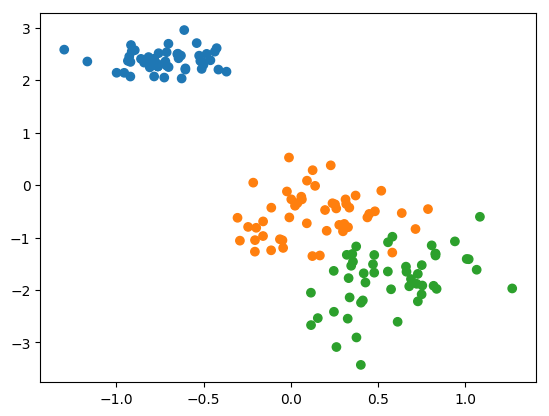

In [23]:
plt = Matplotlib::Pyplot
spices = iris[:species]
colors = spices.tolist.map {|s| "C#{s}" }  # The colors of points
plt.scatter(x_pca[0..-1, 0], x_pca[0..-1, 1], c: colors)

## Visualize Benchmarking Results

In this section, we visualize the results of benchmarking by seaborn's bar plot.

Observation targets are the following 4 ways to calculate array's summation.

1. Array#inject
2. while loop
3. Array#sum
4. Enumerable#sum

In [24]:
require 'benchmark'

N, L = 100, 10_000
ary = Array.new(L) { rand }
methods, times = [], []

N.times do
  # Array#inject -------------------------
  methods << :inject
  times << Benchmark.realtime { ary.inject(:+) }
  # while expr ---------------------------
  methods << :while
  times << Benchmark.realtime {
    sum, i = ary[0], 1
    while i < L
      sum += ary[i]; i += 1
    end
  }
  # Array#sum ----------------------------
  methods << :ary_sum
  times << Benchmark.realtime { ary.sum }
  # Enumerable#sum -----------------------
  methods << :enum_sum
  enum = ary.each
  times << Benchmark.realtime { enum.sum }
end

100

Making a data frame from the observations.

In [25]:
df = Pandas::DataFrame.new(data: { method: methods, time: times })

,method,time
0,inject,0.000535
1,while,0.000417
2,ary_sum,0.000061
3,enum_sum,0.000132
4,inject,0.000308
5,while,0.000338
6,ary_sum,0.000061
7,enum_sum,0.000126
8,inject,0.000487
9,while,0.000356


`groupby` method of a data frame is useful to calculate statistical summaries for each method of summation.

In [26]:
df.groupby(:method).describe

time                                                              \
          count      mean       std       min       25%       50%       75%   
method                                                                        
ary_sum   100.0  0.000057  0.000010  0.000050  0.000052  0.000053  0.000055   
enum_sum  100.0  0.000133  0.000026  0.000119  0.000122  0.000123  0.000127   
inject    100.0  0.000325  0.000056  0.000292  0.000300  0.000301  0.000322   
while     100.0  0.000351  0.000050  0.000318  0.000328  0.000329  0.000354   

                    
               max  
method              
ary_sum   0.000096  
enum_sum  0.000234  
inject    0.000539  
while     0.000587

And then, we can visualize the data frame by passing it to seaborn's function.

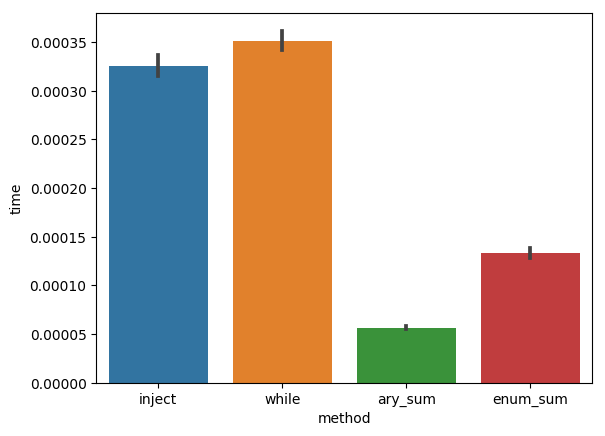

In [27]:
sns = PyCall.import_module('seaborn')
sns.barplot(x: 'method', y: 'time', data: df)

## Using pandas with ActiveRecord

The wrapper library of pandas supports to create a data frame from a connection of ActiveRecord.

You can see the example usage of this feature in the following demonstration Rails app.

https://github.com/mrkn/bugs-viewer-rk2017

The implementation of the feature is here:

https://github.com/mrkn/pandas.rb/blob/master/lib/pandas/io/active_record.rb

## Machine learning with scikit-learn

Of course, we can use scikit-learn through pycall.
There is a great article by Soren D that demonstrates how to use scikit-learn through pycall:

- [Using the scikit-learn machine learning library in Ruby using PyCall](https://www.practicalai.io/using-scikit-learn-machine-learning-library-in-ruby-using-pycall/)

Here, let's try to use scikit-learn's support vector classifier (SVC) with PCA transformer written in Ruby.

This is a minimum implementation of PCA transformer:

In [28]:
class MyPCA
  def fit_transform(x, y=nil, *)
    fit(x, y).transform(x, y)
  end

  def fit(x, y=nil, *)
    x -= Numpy.mean(x, axis: 0)
    _, _, @v = *Numpy.linalg.svd(x, full_matrices: false)
    self
  end

  def transform(x, y=nil, *)
    x -= Numpy.mean(x, axis: 0)
    x.dot(@v)[0..-1, 0...2]
  end
end

:transform

The following code defines a pipeline that combines PCA and SVC.

In [29]:
ModelSelection = PyCall.import_module('sklearn.model_selection')
Pipeline = PyCall.import_module('sklearn.pipeline').Pipeline
SVC = PyCall.import_module('sklearn.svm').SVC

pipe = Pipeline.new([
  PyCall.tuple(['reduce_dim', MyPCA.new]),
  PyCall.tuple(['clf', SVC.new])
])

Pipeline(memory=None,
     steps=[('reduce_dim', <PyCall.ruby_object #<MyPCA:0x00000000030649a8>>), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

And, split data into two parts.  The one is for training, and the other is for testing trained classifier.

In [30]:
x_train, x_test, y_train, y_test = ModelSelection.train_test_split(
  x, iris[:species],
  test_size: 0.4,
  random_state: 0
)

[array([[ 6. ,  3.4,  4.5,  1.6],
       [ 4.8,  3.1,  1.6,  0.2],
       [ 5.8,  2.7,  5.1,  1.9],
       [ 5.6,  2.7,  4.2,  1.3],
       [ 5.6,  2.9,  3.6,  1.3],
       [ 5.5,  2.5,  4. ,  1.3],
       [ 6.1,  3. ,  4.6,  1.4],
       [ 7.2,  3.2,  6. ,  1.8],
       [ 5.3,  3.7,  1.5,  0.2],
       [ 4.3,  3. ,  1.1,  0.1],
       [ 6.4,  2.7,  5.3,  1.9],
       [ 5.7,  3. ,  4.2,  1.2],
       [ 5.4,  3.4,  1.7,  0.2],
       [ 5.7,  4.4,  1.5,  0.4],
       [ 6.9,  3.1,  4.9,  1.5],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5.9,  3. ,  5.1,  1.8],
       [ 5.1,  2.5,  3. ,  1.1],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 6.2,  2.2,  4.5,  1.5],
       [ 7.2,  3.6,  6.1,  2.5],
       [ 5.7,  2.9,  4.2,  1.3],
       [ 4.8,  3. ,  1.4,  0.1],
       [ 7.1,  3. ,  5.9,  2.1],
       [ 6.9,  3.2,  5.7,  2.3],
       [ 6.5,  3. ,  5.8,  2.2],
       [ 6.4,  2.8,  5.6,  2.1],
       [ 5.1,  3.8,  1.6,  0.2],
       [ 4.8,  3.4,  1.6,  0.2],
       [ 6.5,  3.2,  5.1,  2. ],
       [ 

Call `fit` method of the pipeline model with training data to train classifier.

In [31]:
pipe.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('reduce_dim', <PyCall.ruby_object #<MyPCA:0x00000000030649a8 @v=array([[-0.3745 ,  0.06115, -0.85328, -0.35766],
       [ 0.61783,  0.75994, -0.17318, -0.10384],
       [-0.60921,  0.58741,  0.08934,  0.52519],
       [ 0.32694, -0.27147, -0.48367,  0.76516]])>>), ('clf', SVC(C=1.0, cache_si...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Finally, call `score` method with test data to check the precision of the trained model.

In [32]:
pipe.score(x_test, y_test)

0.83333333333333337

Ok, we've done to confirm that we can use scikit-learn with own model written in Ruby.